In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Define a 16x16 FrozenLake map
predefined_map = [
    "SFFFFFFF",
    "FFFHFFFF",
    "FHFFFHFF",
    "FFFFFFFF",
    "HFFFFHFF",
    "FHFHFFFF",
    "FFFFFFHF",
    "FFFFFFFG"
]

# Create the environment with the custom 16x16 map
env = gym.make("FrozenLake-v1", desc=predefined_map, is_slippery=False)

# Get the number of states and actions
states = env.observation_space.n
actions = env.action_space.n
gamma = 0.99

print("States:", states)
print("Actions:", actions)



States: 64
Actions: 4


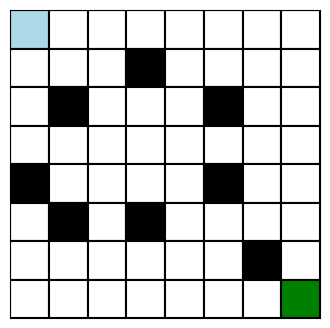

In [ ]:
import matplotlib.pyplot as plt

def display_frozen_lake(desc):
    color_map = {
        'S': 'lightblue',
        'F': 'white',
        'H': 'black',
        'G': 'green'
    }

    grid = np.array(desc)

    fig, ax = plt.subplots(figsize=(len(desc[0]) / 2, len(desc) / 2))

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            color = color_map.get(grid[i, j], 'gray')
            ax.add_patch(plt.Rectangle((j, grid.shape[0] - 1 - i), 1, 1, color=color, ec='black', lw=1.5))

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_xlim(0, grid.shape[1])
    ax.set_ylim(0, grid.shape[0])

    plt.grid(False)
    plt.show()

desc_list = [list(row) for row in predefined_map]
display_frozen_lake(desc_list)


non slippery environment for dynamic programming

Optimal Value Function:
[[0.87752102 0.88638487 0.89533825 0.90438208 0.91351725 0.92274469
  0.93206535 0.94148015]
 [0.88638487 0.89533825 0.90438208 0.         0.92274469 0.93206535
  0.94148015 0.95099005]
 [0.89533825 0.         0.91351725 0.92274469 0.93206535 0.
  0.95099005 0.96059601]
 [0.90438208 0.91351725 0.92274469 0.93206535 0.94148015 0.95099005
  0.96059601 0.970299  ]
 [0.         0.92274469 0.93206535 0.94148015 0.95099005 0.
  0.970299   0.9801    ]
 [0.92274469 0.         0.94148015 0.         0.96059601 0.970299
  0.9801     0.99      ]
 [0.93206535 0.94148015 0.95099005 0.96059601 0.970299   0.9801
  0.         1.        ]
 [0.94148015 0.95099005 0.96059601 0.970299   0.9801     0.99
  1.         0.        ]]

Optimal Policy (0=Left, 1=Down, 2=Right, 3=Up):
[[1 1 1 2 1 1 1 1]
 [1 2 1 0 1 2 1 1]
 [1 0 1 1 1 0 1 1]
 [2 1 1 1 1 2 1 1]
 [0 2 1 2 1 0 1 1]
 [1 0 1 0 1 1 2 1]
 [1 1 1 1 1 1 0 1]
 [2 2 2 2 2 2 2 0]]


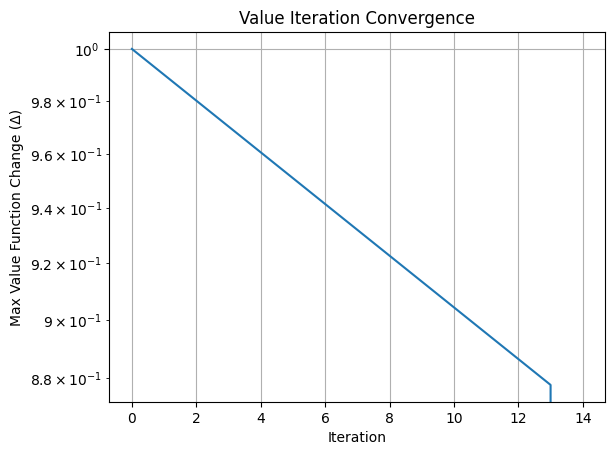

In [ ]:
def value_iteration(env, gamma=0.99, theta=1e-12):
    import numpy as np
    import matplotlib.pyplot as plt

    V = np.zeros(env.observation_space.n)
    policy = np.zeros(env.observation_space.n, dtype=int)
    deltas = []

    while True:
        delta = 0

        for s in range(env.observation_space.n):
            v_old = V[s]
            q_values = np.zeros(env.action_space.n)

            for a in range(env.action_space.n):
                for prob, next_state, reward, done in env.unwrapped.P[s][a]:  # FIXED HERE
                    q_values[a] += prob * (reward + gamma * V[next_state] * (not done))

            V[s] = np.max(q_values)
            policy[s] = np.argmax(q_values)

            delta = max(delta, abs(v_old - V[s]))

        deltas.append(delta)

        if delta < theta:
            break

    return V, policy, deltas

# Make sure to create the environment
import gymnasium as gym

V_opt, policy_opt, deltas = value_iteration(env)

print("Optimal Value Function:")
print(V_opt.reshape((8, 8)))
print("\nOptimal Policy (0=Left, 1=Down, 2=Right, 3=Up):")
print(policy_opt.reshape((8, 8)))

# Plot Learning Curve
import matplotlib.pyplot as plt
plt.plot(deltas)
plt.xlabel("Iteration")
plt.ylabel("Max Value Function Change (Δ)")
plt.title("Value Iteration Convergence")
plt.yscale("log")
plt.grid()
plt.show()


In [ ]:
import numpy as np

def evaluate_policy(env, policy, num_episodes=1000):
    success_count = 0
    total_rewards = []

    goal_state = env.observation_space.n - 1
    hole_states = [i for i, row in enumerate(env.unwrapped.desc.flatten()) if row == b'H']

    for _ in range(num_episodes):
        reset_result = env.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result
        done = False
        total_reward = 0

        while not done:
            action = policy[state]
            step_result = env.step(action)

            if len(step_result) == 4:
                state, reward, done, info = step_result
                truncated = False
            else:
                state, reward, terminated, truncated, info = step_result
                done = terminated or truncated

            total_reward += reward

            # Stop if the agent reaches a hole (failure)
            if state in hole_states:
                done = True

        # Success if agent reaches the goal
        if state == goal_state:
            success_count += 1

        total_rewards.append(total_reward)

    # Compute success rate and average reward
    success_rate = success_count / num_episodes
    avg_reward = np.mean(total_rewards)

    return success_rate, avg_reward

# Run Evaluation
success_rate, avg_reward = evaluate_policy(env, policy_opt)
print(f"Success Rate: {success_rate*100:.2f}%")
print(f"Average Reward: {avg_reward:.2f}")


Success Rate: 100.00%
Average Reward: 1.00


now doing slippery environment for dynamic programming

In [ ]:
slippery_env = gym.make("FrozenLake-v1", desc=predefined_map, is_slippery=True)

In [ ]:
V_opt_slippery, policy_opt_slippery, deltas = value_iteration(slippery_env, 0.95)

print("Optimal Value Function:")
print(V_opt.reshape((8, 8)))
print("\nOptimal Policy (0=Left, 1=Down, 2=Right, 3=Up):")
print(policy_opt.reshape((8, 8)))

success_rate, avg_reward = evaluate_policy(slippery_env, policy_opt_slippery)
print(f"Success Rate: {success_rate*100:.2f}%")
print(f"Average Reward: {avg_reward:.2f}")

Optimal Value Function:
[[0.87752102 0.88638487 0.89533825 0.90438208 0.91351725 0.92274469
  0.93206535 0.94148015]
 [0.88638487 0.89533825 0.90438208 0.         0.92274469 0.93206535
  0.94148015 0.95099005]
 [0.89533825 0.         0.91351725 0.92274469 0.93206535 0.
  0.95099005 0.96059601]
 [0.90438208 0.91351725 0.92274469 0.93206535 0.94148015 0.95099005
  0.96059601 0.970299  ]
 [0.         0.92274469 0.93206535 0.94148015 0.95099005 0.
  0.970299   0.9801    ]
 [0.92274469 0.         0.94148015 0.         0.96059601 0.970299
  0.9801     0.99      ]
 [0.93206535 0.94148015 0.95099005 0.96059601 0.970299   0.9801
  0.         1.        ]
 [0.94148015 0.95099005 0.96059601 0.970299   0.9801     0.99
  1.         0.        ]]

Optimal Policy (0=Left, 1=Down, 2=Right, 3=Up):
[[1 1 1 2 1 1 1 1]
 [1 2 1 0 1 2 1 1]
 [1 0 1 1 1 0 1 1]
 [2 1 1 1 1 2 1 1]
 [0 2 1 2 1 0 1 1]
 [1 0 1 0 1 1 2 1]
 [1 1 1 1 1 1 0 1]
 [2 2 2 2 2 2 2 0]]
Success Rate: 64.60%
Average Reward: 0.65


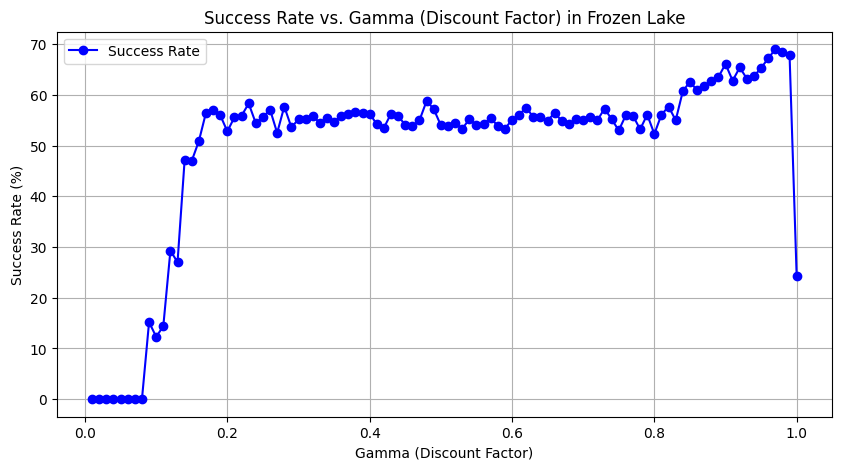

In [ ]:
success_arr=[]
gamma_values = np.arange(0.01, 1.01, 0.01)  # Correct range for gamma values

for gamma in gamma_values:
    V_opt_slippery, policy_opt_slippery, deltas = value_iteration(slippery_env, gamma)
    success_rate, avg_reward = evaluate_policy(slippery_env, policy_opt_slippery)
    success_arr.append(success_rate * 100)

plt.figure(figsize=(10, 5))
plt.plot(gamma_values, success_arr, marker='o', linestyle='-', color='b', label="Success Rate")
plt.xlabel("Gamma (Discount Factor)")
plt.ylabel("Success Rate (%)")
plt.title("Success Rate vs. Gamma (Discount Factor) in Frozen Lake")
plt.legend()
plt.grid(True)
plt.show()

sarsa non slippery environment

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class SARSA:
    def __init__(self, env, alpha, gamma, epsilon, numberEpisodes):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.initial_epsilon = epsilon
        self.numberEpisodes = numberEpisodes

        self.stateNumber = env.observation_space.n
        self.actionNumber = env.action_space.n

        self.Qmatrix = np.zeros((self.stateNumber, self.actionNumber))
        self.learnedPolicy = np.zeros(self.stateNumber, dtype=int)
        self.rewards_per_episode = []

    def selectAction(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.actionNumber)
        else:
            return np.random.choice(np.where(self.Qmatrix[state] == np.max(self.Qmatrix[state]))[0])

    def simulateEpisodes(self):
        for indexEpisode in range(self.numberEpisodes):
            state, _ = self.env.reset()
            action = self.selectAction(state)
            terminalState = False
            total_reward = 0

            while not terminalState:
                new_state, reward, terminalState, _, _ = self.env.step(action)
                new_action = self.selectAction(new_state)

                self.Qmatrix[state, action] += self.alpha * (
                    reward + self.gamma * self.Qmatrix[new_state, new_action] - self.Qmatrix[state, action]
                )

                state, action = new_state, new_action
                total_reward += reward

            self.rewards_per_episode.append(total_reward)

            if (indexEpisode + 1) % 100 == 0:
                self.epsilon = max(self.initial_epsilon * (0.995 ** (indexEpisode // 100)), 0.01)

    def computeFinalPolicy(self):
        for state in range(self.stateNumber):
            self.learnedPolicy[state] = np.argmax(self.Qmatrix[state])

    def evaluatePolicy(self, num_episodes=10000):
        """Evaluates the learned policy by running it for a number of episodes."""
        success_count = 0
        for _ in range(num_episodes):
            state, _ = self.env.reset()
            terminalState = False

            while not terminalState:
                action = self.learnedPolicy[state]
                new_state, reward, terminalState, _, _ = self.env.step(action)
                state = new_state

                if terminalState and reward > 0:
                    success_count += 1

        success_rate = (success_count / num_episodes) * 100
        print(f"Policy Evaluation: Success Rate over {num_episodes} episodes: {success_rate:.2f}%")
        self.print_policy_arrows()
        return success_rate

    def print_policy_arrows(self):
        """Prints the learned policy using arrow symbols."""
        action_symbols = {0: "←", 1: "↓", 2: "→", 3: "↑"}
        policy_grid = np.array([action_symbols[action] for action in self.learnedPolicy]).reshape(8, 8)
        print("\nLearned Policy (Arrows Representation):\n")
        for row in policy_grid:
            print(" ".join(row))

sarsa_agents = []
results = []

def run_sarsa_experiments(env, experiments, numberEpisodes):
    for i, params in enumerate(experiments):
        print(f"\nRunning SARSA Experiment {i+1} with α={params['alpha']}, γ={params['gamma']}, ε={params['epsilon']}")

        agent = SARSA(env, params["alpha"], params["gamma"], params["epsilon"], numberEpisodes)
        agent.simulateEpisodes()
        agent.computeFinalPolicy()
        agent.evaluatePolicy()
        sarsa_agents.append(agent)

        avg_training_success = (sum(agent.rewards_per_episode) / agent.numberEpisodes) * 100
        results.append([params["alpha"], params["gamma"], params["epsilon"], avg_training_success])
        print(f"SARSA Experiment {i+1} - Overall Average Training Success Rate: {avg_training_success:.2f}%")

    df_results = pd.DataFrame(results, columns=["Alpha (α)", "Gamma (γ)", "Epsilon (ε)", "Avg Training Success Rate (%)"])
    return df_results

predefined_map = [
    "SFFFFFFF",
    "FFFHFFFF",
    "FHFFFHFF",
    "FFFFFFFF",
    "HFFFFHFF",
    "FHFHFFFF",
    "FFFFFFHF",
    "FFFFFFFG"
]

env = gym.make('FrozenLake-v1', desc=predefined_map, is_slippery=False)

experiments = [
    {"alpha": 0.1, "gamma": 0.9, "epsilon": 0.2, "numberEpisodes": 20000},
    {"alpha": 0.15, "gamma": 0.95, "epsilon": 0.25, "numberEpisodes": 20000},
    {"alpha": 0.05, "gamma": 0.99, "epsilon": 0.15, "numberEpisodes": 20000}
]

df_results = run_sarsa_experiments(env, experiments, 20000)

print("\nFinal Table - Average Training Success Rate Across SARSA Experiments:")
print(df_results)



Running SARSA Experiment 1 with α=0.1, γ=0.9, ε=0.2
Policy Evaluation: Success Rate over 10000 episodes: 100.00%

Learned Policy (Arrows Representation):

→ → → → → → → ↓
→ ↑ ↑ ← → → → ↓
↑ ← ↑ → ↑ ← → ↓
← ← ← ↑ ← → ↓ ↓
← ← ← ← ↓ ← ↓ ↓
← ← ← ← → → → ↓
← ← ← ← ← ← ← ↓
← ← ← ← ← → → ←
SARSA Experiment 1 - Overall Average Training Success Rate: 64.80%

Running SARSA Experiment 2 with α=0.15, γ=0.95, ε=0.25
Policy Evaluation: Success Rate over 10000 episodes: 100.00%

Learned Policy (Arrows Representation):

↓ ← ← ← ↓ ← ← ←
→ → ↓ ← ↓ ← ← ←
↑ ← ↓ ↓ ↓ ← ← ←
→ → → → ↓ ← ← ←
← → ↑ → ↓ ← ↑ ←
← ← ↑ ← ↓ ↓ ← ←
← ← → → ↓ ↓ ← ↓
← ← ↑ → → → → ←
SARSA Experiment 2 - Overall Average Training Success Rate: 55.33%

Running SARSA Experiment 3 with α=0.05, γ=0.99, ε=0.15
Policy Evaluation: Success Rate over 10000 episodes: 100.00%

Learned Policy (Arrows Representation):

→ → → → → → ↓ ↓
↑ ↑ ↑ ← ↑ ↑ → ↓
↑ ← ↑ ← ↑ ← ↑ ↓
← ← ← → → → → ↓
← ← ← ← ↑ ← → ↓
← ← ← ← ← → → ↓
← ← ← ← ← ← ← ↓
← ← ← ← ← ← ← ←
SARSA Ex

sarsa slippery environment

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class SARSA:
    def __init__(self, env, alpha, gamma, epsilon, numberEpisodes):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.initial_epsilon = epsilon
        self.numberEpisodes = numberEpisodes

        self.stateNumber = env.observation_space.n
        self.actionNumber = env.action_space.n

        self.Qmatrix = np.zeros((self.stateNumber, self.actionNumber))
        self.learnedPolicy = np.zeros(self.stateNumber, dtype=int)
        self.rewards_per_episode = []

    def selectAction(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.actionNumber)
        else:
            return np.random.choice(np.where(self.Qmatrix[state] == np.max(self.Qmatrix[state]))[0])

    def simulateEpisodes(self):
        for indexEpisode in range(self.numberEpisodes):
            state, _ = self.env.reset()
            action = self.selectAction(state)
            terminalState = False
            total_reward = 0

            while not terminalState:
                new_state, reward, terminalState, _, _ = self.env.step(action)
                new_action = self.selectAction(new_state)

                self.Qmatrix[state, action] += self.alpha * (
                    reward + self.gamma * self.Qmatrix[new_state, new_action] - self.Qmatrix[state, action]
                )

                state, action = new_state, new_action
                total_reward += reward

            self.rewards_per_episode.append(total_reward)

            if (indexEpisode + 1) % 100 == 0:
                self.epsilon = max(self.initial_epsilon * (0.995 ** (indexEpisode // 100)), 0.01)

    def computeFinalPolicy(self):
        for state in range(self.stateNumber):
            self.learnedPolicy[state] = np.argmax(self.Qmatrix[state])

    def evaluatePolicy(self, num_episodes=10000):
        """Evaluates the learned policy by running it for a number of episodes."""
        success_count = 0
        for _ in range(num_episodes):
            state, _ = self.env.reset()
            terminalState = False

            while not terminalState:
                action = self.learnedPolicy[state]
                new_state, reward, terminalState, _, _ = self.env.step(action)
                state = new_state

                if terminalState and reward > 0:
                    success_count += 1

        success_rate = (success_count / num_episodes) * 100
        print(f"Policy Evaluation: Success Rate over {num_episodes} episodes: {success_rate:.2f}%")
        self.print_policy_arrows()
        return success_rate

    def print_policy_arrows(self):
        """Prints the learned policy using arrow symbols."""
        action_symbols = {0: "←", 1: "↓", 2: "→", 3: "↑"}
        policy_grid = np.array([action_symbols[action] for action in self.learnedPolicy]).reshape(8, 8)
        print("\nLearned Policy (Arrows Representation):\n")
        for row in policy_grid:
            print(" ".join(row))

sarsa_agents = []
results = []

def run_sarsa_experiments(env, experiments, numberEpisodes):
    for i, params in enumerate(experiments):
        print(f"\nRunning SARSA Experiment {i+1} with α={params['alpha']}, γ={params['gamma']}, ε={params['epsilon']}")

        agent = SARSA(env, params["alpha"], params["gamma"], params["epsilon"], numberEpisodes)
        agent.simulateEpisodes()
        agent.computeFinalPolicy()
        agent.evaluatePolicy()
        sarsa_agents.append(agent)

        avg_training_success = (sum(agent.rewards_per_episode) / agent.numberEpisodes) * 100
        results.append([params["alpha"], params["gamma"], params["epsilon"], avg_training_success])
        print(f"SARSA Experiment {i+1} - Overall Average Training Success Rate: {avg_training_success:.2f}%")

    df_results = pd.DataFrame(results, columns=["Alpha (α)", "Gamma (γ)", "Epsilon (ε)", "Avg Training Success Rate (%)"])
    return df_results

predefined_map = [
    "SFFFFFFF",
    "FFFHFFFF",
    "FHFFFHFF",
    "FFFFFFFF",
    "HFFFFHFF",
    "FHFHFFFF",
    "FFFFFFHF",
    "FFFFFFFG"
]

env = gym.make('FrozenLake-v1', desc=predefined_map, is_slippery=True)

experiments = [
    {"alpha": 0.1, "gamma": 0.9, "epsilon": 0.2, "numberEpisodes": 20000},
    {"alpha": 0.15, "gamma": 0.95, "epsilon": 0.25, "numberEpisodes": 20000},
    {"alpha": 0.05, "gamma": 0.99, "epsilon": 0.15, "numberEpisodes": 20000}
]

df_results = run_sarsa_experiments(env, experiments, 20000)

print("\nFinal Table - Average Training Success Rate Across SARSA Experiments:")
print(df_results)



Running SARSA Experiment 1 with α=0.1, γ=0.9, ε=0.2
Policy Evaluation: Success Rate over 10000 episodes: 70.70%

Learned Policy (Arrows Representation):

↓ → → ↑ → ↓ → ↓
↑ ↑ ← ← → ↑ → ↓
← ← → ↓ ← ← → →
↑ ↓ → ↓ → ↑ ↓ →
← → → ↑ ← ← → →
↓ ← → ← → ↓ ↑ →
↓ ↓ ↓ ↓ → ← ← →
↑ → → → → ↓ ↓ ←
SARSA Experiment 1 - Overall Average Training Success Rate: 18.12%

Running SARSA Experiment 2 with α=0.15, γ=0.95, ε=0.25
Policy Evaluation: Success Rate over 10000 episodes: 79.92%

Learned Policy (Arrows Representation):

→ ↑ → ↑ → → → ↓
↑ ↑ ← ← → ↑ → →
← ← → ↓ ← ← → ↓
↑ ↓ → → → ↓ → ↓
← → → ↑ ← ← → ↓
↓ ← ← ← → ↓ ↑ ↓
→ ↓ ↓ ↓ → ← ← →
↓ → → ↓ ↓ ↓ ↓ ←
SARSA Experiment 2 - Overall Average Training Success Rate: 17.92%

Running SARSA Experiment 3 with α=0.05, γ=0.99, ε=0.15
Policy Evaluation: Success Rate over 10000 episodes: 94.37%

Learned Policy (Arrows Representation):

↑ ↑ ↑ ↑ ↑ → → ↓
↑ ↑ ← ← → ↑ → ↓
→ ← → ↓ ← ← → ↓
← → → ↑ ↑ ↓ → →
← ↑ → → ← ← → →
↓ ← → ← → ↓ ↑ →
→ ↓ ← ↓ → → ← →
↑ → ↑ → ↑ ↓ ↑ ←
SARSA Exper

sarsa novelty non slippery environment

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class SARSA:
    def __init__(self, env, alpha, gamma, epsilon, numberEpisodes, beta=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.initial_epsilon = epsilon
        self.numberEpisodes = numberEpisodes
        self.beta = beta  # Coefficient for intrinsic reward (novelty)

        self.stateNumber = env.observation_space.n
        self.actionNumber = env.action_space.n

        self.Qmatrix = np.zeros((self.stateNumber, self.actionNumber))
        self.learnedPolicy = np.zeros(self.stateNumber, dtype=int)
        self.rewards_per_episode = []
        self.visit_count = np.zeros((self.stateNumber, self.actionNumber))  # Track state-action visits

    def selectAction(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.actionNumber)
        else:
            return np.random.choice(np.where(self.Qmatrix[state] == np.max(self.Qmatrix[state]))[0])

    def compute_intrinsic_reward(self, state, action):
        """Computes an intrinsic novelty reward based on visit counts."""
        self.visit_count[state, action] += 1  # Update visit count
        return self.beta / np.sqrt(self.visit_count[state, action])  # Novelty reward

    def simulateEpisodes(self):
        for indexEpisode in range(self.numberEpisodes):
            state, _ = self.env.reset()
            action = self.selectAction(state)
            terminalState = False
            total_reward = 0

            while not terminalState:
                new_state, reward, terminalState, _, _ = self.env.step(action)

                # Compute intrinsic reward
                intrinsic_reward = self.compute_intrinsic_reward(state, action)
                reward += intrinsic_reward  # Add intrinsic reward
                total_reward += reward

                new_action = self.selectAction(new_state)

                self.Qmatrix[state, action] += self.alpha * (
                    reward + self.gamma * self.Qmatrix[new_state, new_action] - self.Qmatrix[state, action]
                )

                state, action = new_state, new_action

            self.rewards_per_episode.append(total_reward)

            if (indexEpisode + 1) % 100 == 0:
                self.epsilon = max(self.initial_epsilon * (0.995 ** (indexEpisode // 100)), 0.01)

    def computeFinalPolicy(self):
        for state in range(self.stateNumber):
            self.learnedPolicy[state] = np.argmax(self.Qmatrix[state])

    def evaluatePolicy(self, num_episodes=10000):
        """Evaluates the learned policy by running it for a number of episodes."""
        success_count = 0
        for _ in range(num_episodes):
            state, _ = self.env.reset()
            terminalState = False

            while not terminalState:
                action = self.learnedPolicy[state]
                new_state, reward, terminalState, _, _ = self.env.step(action)
                state = new_state

                if terminalState and reward > 0:
                    success_count += 1

        success_rate = (success_count / num_episodes) * 100
        print(f"Policy Evaluation: Success Rate over {num_episodes} episodes: {success_rate:.2f}%")
        self.print_policy_arrows()
        return success_rate

    def print_policy_arrows(self):
        """Prints the learned policy using arrow symbols."""
        action_symbols = {0: "←", 1: "↓", 2: "→", 3: "↑"}
        policy_grid = np.array([action_symbols[action] for action in self.learnedPolicy]).reshape(8, 8)
        print("\nLearned Policy (Arrows Representation):\n")
        for row in policy_grid:
            print(" ".join(row))

sarsa_agents = []
results = []

def run_sarsa_experiments(env, experiments, numberEpisodes):
    for i, params in enumerate(experiments):
        beta = params.get("beta", 0.1)  # Default beta to 0.1 if missing

        print(f"\nRunning SARSA Experiment {i+1} with α={params['alpha']}, γ={params['gamma']}, ε={params['epsilon']}, β={beta}")

        agent = SARSA(env, params["alpha"], params["gamma"], params["epsilon"], numberEpisodes, beta)
        agent.simulateEpisodes()
        agent.computeFinalPolicy()
        agent.evaluatePolicy()
        sarsa_agents.append(agent)

        avg_training_success = (sum(agent.rewards_per_episode) / agent.numberEpisodes) * 100
        results.append([params["alpha"], params["gamma"], params["epsilon"], beta, avg_training_success])
        print(f"SARSA Experiment {i+1} - Overall Average Training Success Rate: {avg_training_success:.2f}%")

    df_results = pd.DataFrame(results, columns=["Alpha (α)", "Gamma (γ)", "Epsilon (ε)", "Beta (β)", "Avg Training Success Rate (%)"])
    return df_results

predefined_map = [
    "SFFFFFFF",
    "FFFHFFFF",
    "FHFFFHFF",
    "FFFFFFFF",
    "HFFFFHFF",
    "FHFHFFFF",
    "FFFFFFHF",
    "FFFFFFFG"
]

env = gym.make('FrozenLake-v1', desc=predefined_map, is_slippery=False)

experiments = [
    {"alpha": 0.1, "gamma": 0.9, "epsilon": 0.2, "numberEpisodes": 20000, "beta": 0.1},
    {"alpha": 0.15, "gamma": 0.95, "epsilon": 0.25, "numberEpisodes": 20000, "beta": 0.1},
    {"alpha": 0.05, "gamma": 0.99, "epsilon": 0.15, "numberEpisodes": 20000, "beta": 0.05}
]

df_results = run_sarsa_experiments(env, experiments, 20000)

print("\nFinal Table - Average Training Success Rate Across SARSA Experiments:")
print(df_results)



Running SARSA Experiment 1 with α=0.1, γ=0.9, ε=0.2, β=0.1
Policy Evaluation: Success Rate over 10000 episodes: 100.00%

Learned Policy (Arrows Representation):

→ → → → → → → ↓
↑ → ↑ ← → → → ↓
↓ ← ↓ ↓ ↓ ← → ↓
→ → → → ↓ ← → ↓
← → ↑ → ↓ ← → ↓
→ ← ↑ ← → → → ↓
↓ ← ↓ ↓ → ↑ ← ↓
↑ ← ↑ ↑ ↑ ↑ ← ←
SARSA Experiment 1 - Overall Average Training Success Rate: 92.76%

Running SARSA Experiment 2 with α=0.15, γ=0.95, ε=0.25, β=0.1
Policy Evaluation: Success Rate over 10000 episodes: 100.00%

Learned Policy (Arrows Representation):

→ → → → → → → ↓
↑ ↑ ↑ ← ↑ → → ↓
↑ ← ↑ ← ← ← ↓ ↓
↑ ← ← ↓ ← → → ↓
← ← → ↓ ← ← → ↓
← ← ← ← ← → → ↓
← ← ← ↓ ↑ ↓ ← ↓
← ← ← ↑ ↑ ← ← ←
SARSA Experiment 2 - Overall Average Training Success Rate: 91.55%

Running SARSA Experiment 3 with α=0.05, γ=0.99, ε=0.15, β=0.05
Policy Evaluation: Success Rate over 10000 episodes: 100.00%

Learned Policy (Arrows Representation):

→ → → → → → → ↓
↑ ↑ ↑ ← ↑ ↑ → ↓
↑ ← ↑ ↓ ↓ ← → ↓
↑ ← ← ← ← ← → ↓
← ↓ ↑ → ↑ ← ↑ ↓
← ← ← ← ← → → ↓
← ← ← ← ← → ← ↓
← 

sarsa novelty slippery environment

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class SARSA:
    def __init__(self, env, alpha, gamma, epsilon, numberEpisodes, beta=0.1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.initial_epsilon = epsilon
        self.numberEpisodes = numberEpisodes
        self.beta = beta  # Coefficient for intrinsic reward (novelty)

        self.stateNumber = env.observation_space.n
        self.actionNumber = env.action_space.n

        self.Qmatrix = np.zeros((self.stateNumber, self.actionNumber))
        self.learnedPolicy = np.zeros(self.stateNumber, dtype=int)
        self.rewards_per_episode = []
        self.visit_count = np.zeros((self.stateNumber, self.actionNumber))  # Track state-action visits

    def selectAction(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.actionNumber)
        else:
            return np.random.choice(np.where(self.Qmatrix[state] == np.max(self.Qmatrix[state]))[0])

    def compute_intrinsic_reward(self, state, action):
        """Computes an intrinsic novelty reward based on visit counts."""
        self.visit_count[state, action] += 1  # Update visit count
        return self.beta / np.sqrt(self.visit_count[state, action])  # Novelty reward

    def simulateEpisodes(self):
        for indexEpisode in range(self.numberEpisodes):
            state, _ = self.env.reset()
            action = self.selectAction(state)
            terminalState = False
            total_reward = 0

            while not terminalState:
                new_state, reward, terminalState, _, _ = self.env.step(action)

                # Compute intrinsic reward
                intrinsic_reward = self.compute_intrinsic_reward(state, action)
                reward += intrinsic_reward  # Add intrinsic reward
                total_reward += reward

                new_action = self.selectAction(new_state)

                self.Qmatrix[state, action] += self.alpha * (
                    reward + self.gamma * self.Qmatrix[new_state, new_action] - self.Qmatrix[state, action]
                )

                state, action = new_state, new_action

            self.rewards_per_episode.append(total_reward)

            if (indexEpisode + 1) % 100 == 0:
                self.epsilon = max(self.initial_epsilon * (0.995 ** (indexEpisode // 100)), 0.01)

    def computeFinalPolicy(self):
        for state in range(self.stateNumber):
            self.learnedPolicy[state] = np.argmax(self.Qmatrix[state])

    def evaluatePolicy(self, num_episodes=10000):
        """Evaluates the learned policy by running it for a number of episodes."""
        success_count = 0
        for _ in range(num_episodes):
            state, _ = self.env.reset()
            terminalState = False

            while not terminalState:
                action = self.learnedPolicy[state]
                new_state, reward, terminalState, _, _ = self.env.step(action)
                state = new_state

                if terminalState and reward > 0:
                    success_count += 1

        success_rate = (success_count / num_episodes) * 100
        print(f"Policy Evaluation: Success Rate over {num_episodes} episodes: {success_rate:.2f}%")
        self.print_policy_arrows()
        return success_rate

    def print_policy_arrows(self):
        """Prints the learned policy using arrow symbols."""
        action_symbols = {0: "←", 1: "↓", 2: "→", 3: "↑"}
        policy_grid = np.array([action_symbols[action] for action in self.learnedPolicy]).reshape(8, 8)
        print("\nLearned Policy (Arrows Representation):\n")
        for row in policy_grid:
            print(" ".join(row))

sarsa_agents = []
results = []

def run_sarsa_experiments(env, experiments, numberEpisodes):
    for i, params in enumerate(experiments):
        beta = params.get("beta", 0.1)  # Default beta to 0.1 if missing

        print(f"\nRunning SARSA Experiment {i+1} with α={params['alpha']}, γ={params['gamma']}, ε={params['epsilon']}, β={beta}")

        agent = SARSA(env, params["alpha"], params["gamma"], params["epsilon"], numberEpisodes, beta)
        agent.simulateEpisodes()
        agent.computeFinalPolicy()
        agent.evaluatePolicy()
        sarsa_agents.append(agent)

        avg_training_success = (sum(agent.rewards_per_episode) / agent.numberEpisodes) * 100
        results.append([params["alpha"], params["gamma"], params["epsilon"], beta, avg_training_success])
        print(f"SARSA Experiment {i+1} - Overall Average Training Success Rate: {avg_training_success:.2f}%")

    df_results = pd.DataFrame(results, columns=["Alpha (α)", "Gamma (γ)", "Epsilon (ε)", "Beta (β)", "Avg Training Success Rate (%)"])
    return df_results

predefined_map = [
    "SFFFFFFF",
    "FFFHFFFF",
    "FHFFFHFF",
    "FFFFFFFF",
    "HFFFFHFF",
    "FHFHFFFF",
    "FFFFFFHF",
    "FFFFFFFG"
]

env = gym.make('FrozenLake-v1', desc=predefined_map, is_slippery=True)

experiments = [
    {"alpha": 0.1, "gamma": 0.9, "epsilon": 0.2, "numberEpisodes": 20000, "beta": 0.1},
    {"alpha": 0.15, "gamma": 0.95, "epsilon": 0.25, "numberEpisodes": 20000, "beta": 0.1},
    {"alpha": 0.05, "gamma": 0.99, "epsilon": 0.15, "numberEpisodes": 20000, "beta": 0.05}
]

df_results = run_sarsa_experiments(env, experiments, 20000)

print("\nFinal Table - Average Training Success Rate Across SARSA Experiments:")
print(df_results)



Running SARSA Experiment 1 with α=0.1, γ=0.9, ε=0.2, β=0.1
Policy Evaluation: Success Rate over 10000 episodes: 78.03%

Learned Policy (Arrows Representation):

↑ ↑ → ↑ ↓ → → ←
↓ ↑ ← ← → ↑ → ←
← ← → ↓ ← ← → ↓
↑ ↓ → → → ↓ → →
← → → ↑ ← ← → ↓
→ ← ↓ ← → ↓ ↑ →
↓ ↓ ↓ ↓ ↓ ← ← →
→ ↑ → → → ↓ ↓ ←
SARSA Experiment 1 - Overall Average Training Success Rate: 26.57%

Running SARSA Experiment 2 with α=0.15, γ=0.95, ε=0.25, β=0.1
Policy Evaluation: Success Rate over 10000 episodes: 74.14%

Learned Policy (Arrows Representation):

↑ → → ↑ → → → ↓
→ ↑ ← ← → ↑ ↓ ↓
← ← → ↓ ← ← → ↓
↑ ↓ → ↓ ↓ ↓ → ↓
← → → ↑ ← ← → ←
← ← → ← → ↓ ↑ →
↓ ↓ ↓ ↓ ↓ ← ← →
→ → → → ↓ → ↓ ←
SARSA Experiment 2 - Overall Average Training Success Rate: 28.88%

Running SARSA Experiment 3 with α=0.05, γ=0.99, ε=0.15, β=0.05
Policy Evaluation: Success Rate over 10000 episodes: 91.17%

Learned Policy (Arrows Representation):

↑ ↑ ↑ ↑ → → → ←
↑ ↑ ← ← → ↑ → ↓
↑ ← → ↓ ← ← → ↓
→ → → ↑ → ↓ → ↓
← ↑ ↑ ↑ ← ← → →
← ← ↑ ← → ↓ ↑ →
→ ↓ ↓ ↓ → ← ← →
↑ ↓ ↑